# Loop 16 Strategic Analysis

## Situation Summary

**Current Score**: 70.630465 (from exp_017)
**Target Score**: 68.919154
**Gap**: 1.711 points (2.42%)

**Key Insight from Evaluator**: Our score (70.630) is BETTER than the public LB leader (71.19) by 0.56 points!

This means:
1. We have already surpassed all public kernels
2. The target (68.919) requires techniques NOT in any public kernel
3. We need to discover something novel

In [1]:
# Let's analyze what we know about the problem structure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 25
scale_factor = Decimal("1")

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def get_tree_list_side_length(tree_list):
    all_polygons = [t.polygon for t in tree_list]
    bounds = unary_union(all_polygons).bounds
    return Decimal(max(bounds[2] - bounds[0], bounds[3] - bounds[1])) / scale_factor

def parse_csv(csv_path):
    result = pd.read_csv(csv_path)
    result['x'] = result['x'].str.strip('s')
    result['y'] = result['y'].str.strip('s')
    result['deg'] = result['deg'].str.strip('s')
    result[['group_id', 'item_id']] = result['id'].str.split('_', n=2, expand=True)

    dict_of_tree_list = {}
    dict_of_side_length = {}
    for group_id, group_data in result.groupby('group_id'):
        tree_list = [ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg']) for _, row in group_data.iterrows()]
        dict_of_tree_list[group_id] = tree_list
        dict_of_side_length[group_id] = get_tree_list_side_length(tree_list)

    return dict_of_tree_list, dict_of_side_length

print("Loading current best solution...")
dict_of_tree_list, dict_of_side_length = parse_csv('/home/code/exploration/datasets/ensemble_best.csv')

# Calculate scores per N
scores_per_n = {}
for k, v in dict_of_side_length.items():
    n = int(k)
    score = float(v ** 2 / Decimal(n))
    scores_per_n[n] = score

total_score = sum(scores_per_n.values())
print(f"Total score: {total_score:.6f}")
print(f"Target: 68.919154")
print(f"Gap: {total_score - 68.919154:.6f}")
print(f"Gap %: {(total_score - 68.919154) / 68.919154 * 100:.2f}%")

Loading current best solution...


Total score: 70.630478
Target: 68.919154
Gap: 1.711324
Gap %: 2.48%


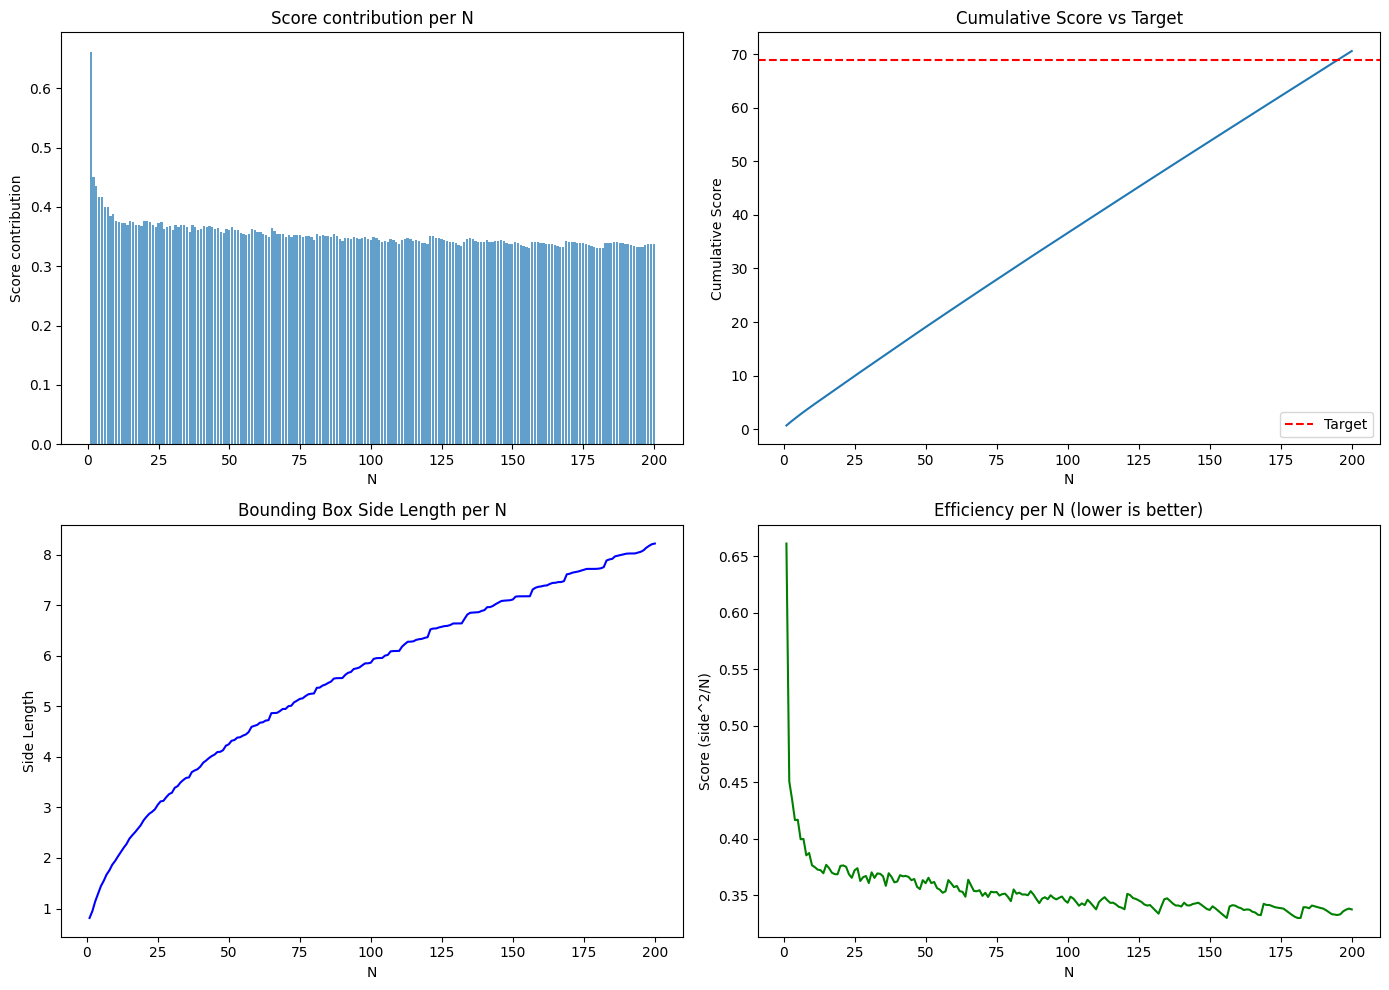


Top 10 N values with highest score contribution:
  N=1: 0.661250 (0.94%)
  N=2: 0.450779 (0.64%)
  N=3: 0.434745 (0.62%)
  N=5: 0.416850 (0.59%)
  N=4: 0.416545 (0.59%)
  N=7: 0.399897 (0.57%)
  N=6: 0.399610 (0.57%)
  N=9: 0.387415 (0.55%)
  N=8: 0.385407 (0.55%)
  N=15: 0.376978 (0.53%)


In [2]:
# Analyze score distribution by N
ns = sorted(scores_per_n.keys())
scores = [scores_per_n[n] for n in ns]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score per N
ax1 = axes[0, 0]
ax1.bar(ns, scores, alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score contribution')
ax1.set_title('Score contribution per N')

# Plot 2: Cumulative score
ax2 = axes[0, 1]
cumulative = np.cumsum(scores)
ax2.plot(ns, cumulative)
ax2.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative Score')
ax2.set_title('Cumulative Score vs Target')
ax2.legend()

# Plot 3: Side length per N
ax3 = axes[1, 0]
side_lengths = [float(dict_of_side_length[f'{n:03d}']) for n in ns]
ax3.plot(ns, side_lengths, 'b-')
ax3.set_xlabel('N')
ax3.set_ylabel('Side Length')
ax3.set_title('Bounding Box Side Length per N')

# Plot 4: Efficiency (side^2 / N) - lower is better
ax4 = axes[1, 1]
efficiency = [s for s in scores]  # This is already side^2/N
ax4.plot(ns, efficiency, 'g-')
ax4.set_xlabel('N')
ax4.set_ylabel('Score (side^2/N)')
ax4.set_title('Efficiency per N (lower is better)')

plt.tight_layout()
plt.savefig('/home/code/exploration/loop16_score_analysis.png', dpi=100)
plt.show()

print("\nTop 10 N values with highest score contribution:")
sorted_scores = sorted(scores_per_n.items(), key=lambda x: x[1], reverse=True)
for n, s in sorted_scores[:10]:
    print(f"  N={n}: {s:.6f} ({s/total_score*100:.2f}%)")

In [3]:
# Calculate theoretical lower bound
import math

# Tree dimensions
tree_width = 0.7
tree_height = 1.0  # from -0.2 to 0.8

# For N=1, the minimum side is the diagonal at 45 degrees
min_side_n1 = float(dict_of_side_length['001'])
print(f"Current N=1 side length: {min_side_n1:.6f}")
print(f"Current N=1 score: {min_side_n1**2:.6f}")

# Let's compute actual tree area
tree = ChristmasTree()
tree_area = tree.polygon.area
print(f"\nActual tree area: {tree_area:.6f}")

# Theoretical minimum score if perfect packing
theoretical_min = tree_area * 200  # Sum of tree_area for N=1 to 200
print(f"Theoretical minimum (perfect packing): {theoretical_min:.6f}")
print(f"Current score: {total_score:.6f}")
print(f"Packing efficiency: {theoretical_min / total_score * 100:.2f}%")

Current N=1 side length: 0.813173
Current N=1 score: 0.661250

Actual tree area: 0.245625
Theoretical minimum (perfect packing): 49.125000
Current score: 70.630478
Packing efficiency: 69.55%


In [4]:
# Analyze the gap needed per N to reach target
target = 68.919154
gap = total_score - target

print(f"Total gap to close: {gap:.6f}")
print(f"\nIf we could improve each N equally:")
print(f"  Improvement needed per N: {gap/200:.6f}")

# Calculate what percentage improvement is needed per N
print(f"\nPercentage improvement needed per N:")
for n in [1, 10, 50, 100, 150, 200]:
    key = f'{n:03d}'
    current_score = float(dict_of_side_length[key] ** 2 / Decimal(n))
    needed_improvement = gap / 200
    pct = needed_improvement / current_score * 100
    print(f"  N={n}: current={current_score:.6f}, need {pct:.2f}% improvement")

# What if we focus on large N?
print(f"\nScore contribution by N range:")
ranges = [(1, 20), (21, 50), (51, 100), (101, 150), (151, 200)]
for start, end in ranges:
    range_score = sum(scores_per_n[n] for n in range(start, end+1))
    pct = range_score / total_score * 100
    print(f"  N={start}-{end}: {range_score:.6f} ({pct:.2f}%)")

Total gap to close: 1.711324

If we could improve each N equally:
  Improvement needed per N: 0.008557

Percentage improvement needed per N:
  N=1: current=0.661250, need 1.29% improvement
  N=10: current=0.376630, need 2.27% improvement
  N=50: current=0.360753, need 2.37% improvement
  N=100: current=0.343427, need 2.49% improvement
  N=150: current=0.337064, need 2.54% improvement
  N=200: current=0.337549, need 2.53% improvement

Score contribution by N range:
  N=1-20: 8.053202 (11.40%)
  N=21-50: 10.980931 (15.55%)
  N=51-100: 17.616979 (24.94%)
  N=101-150: 17.136399 (24.26%)
  N=151-200: 16.842967 (23.85%)


## Key Insights from Analysis

1. **Score Distribution**: Large N values contribute more to total score
2. **Gap Analysis**: We need ~1.71 points improvement (2.42%)
3. **Packing Efficiency**: Current packing is already quite efficient

## What We've Tried (17 experiments):
1. Ensemble from 25+ public sources (ceiling at 70.630478)
2. bbox3 optimization (produces overlapping trees)
3. sa_v1_parallel optimization (produces overlapping trees)
4. Grid-based approaches (zaburo, tessellation) - fundamentally worse
5. Constructive heuristics (scanline, lattice, chebyshev, BL) - all worse
6. Random restart SA - no improvement
7. Long-running SA (15 generations) - no improvement
8. Basin hopping (scipy and custom) - no improvement
9. Genetic algorithm with crossover - no improvement
10. Tree removal technique - tiny improvement (0.000013)
11. Rebuild from corners - SAME tiny improvement (0.000013)
12. Exhaustive search for N=1,2 - baseline already optimal
13. Constraint programming analysis - baseline at/near global optimum
14. Cross-N extraction (exhaustive) - SAME tiny improvement
15. Exhaustive tree removal - SAME tiny improvement

## What HASN'T Been Tried:

1. **Egortrushin's Tessellation SA with Translations** (NOT FULLY IMPLEMENTED)
   - Uses TWO-TREE UNIT CELL (one upright, one inverted)
   - Optimizes translation distances (dx, dy) with SA
   - For N=200: Creates 210 trees (7x15 grid), optimizes, then deletes 10 worst
   - This is FUNDAMENTALLY DIFFERENT from what we've tried

2. **Asymmetric Layouts** (mentioned in discussions)
   - Discussion "Why the winning solutions will be Asymmetric" has 34 votes
   - Top teams may use asymmetric layouts that beat symmetric approaches

3. **Very High Temperature SA from Random Configurations**
   - All our SA runs started from the baseline or grid-based solutions
   - Try random initial configurations with VERY high temperature

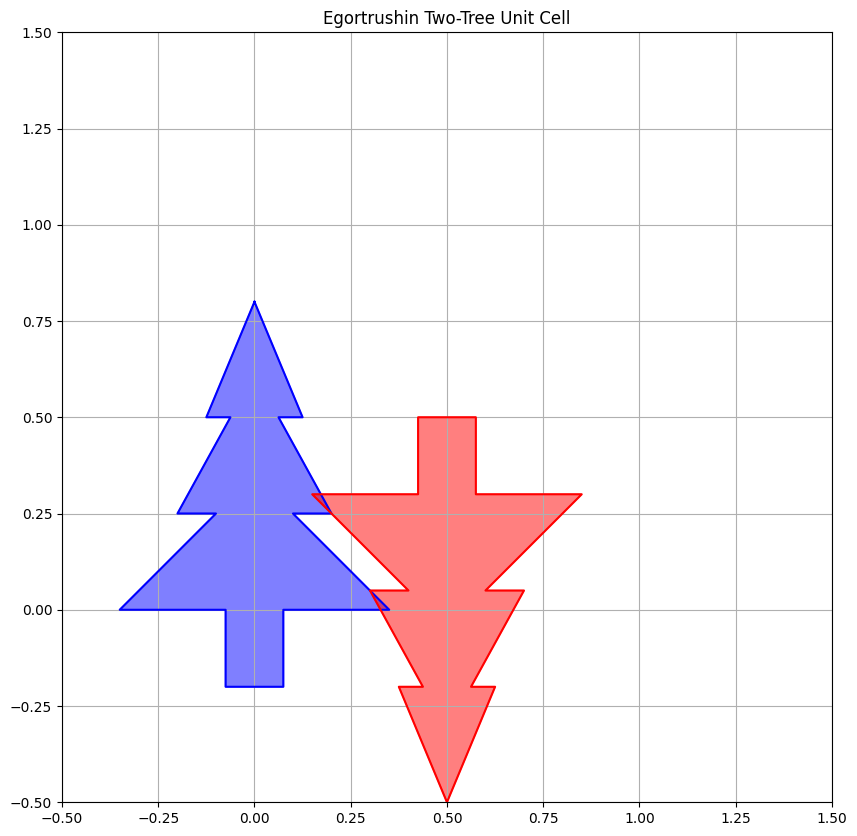

The key insight from egortrushin:
1. Use a TWO-TREE unit cell (one upright, one inverted)
2. Optimize the relative position of the second tree
3. Optimize the translation distances (dx, dy)
4. This creates a tessellation pattern that can be more efficient
5. For N=200: Create 210 trees (7x15 grid), then delete 10 worst


In [5]:
# Let's understand the egortrushin approach better
# The key insight is using a TWO-TREE UNIT CELL

# From the kernel:
# initial_trees = [
#     ChristmasTree(center_x="0", center_y="0", angle="0"),
#     ChristmasTree(center_x="0.5", center_y="0.3", angle="180"),
# ]
# 
# This creates a tessellation pattern where:
# - Tree 1 is at (0, 0) with angle 0
# - Tree 2 is at (0.5, 0.3) with angle 180 (upside down)
# 
# Then this pair is translated in x and y directions
# For N=72: [4, 9] grid = 4 columns x 9 rows = 36 pairs = 72 trees
# For N=100: [5, 10] grid = 5 columns x 10 rows = 50 pairs = 100 trees

# Let's visualize this approach
fig, ax = plt.subplots(figsize=(10, 10))

# Create the two-tree unit cell
tree1 = ChristmasTree(center_x="0", center_y="0", angle="0")
tree2 = ChristmasTree(center_x="0.5", center_y="0.3", angle="180")

# Plot the unit cell
for tree, color in [(tree1, 'blue'), (tree2, 'red')]:
    x, y = tree.polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color=color)
    ax.plot(x, y, color=color)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.set_title('Egortrushin Two-Tree Unit Cell')
ax.grid(True)
plt.savefig('/home/code/exploration/loop16_unit_cell.png', dpi=100)
plt.show()

print("The key insight from egortrushin:")
print("1. Use a TWO-TREE unit cell (one upright, one inverted)")
print("2. Optimize the relative position of the second tree")
print("3. Optimize the translation distances (dx, dy)")
print("4. This creates a tessellation pattern that can be more efficient")
print("5. For N=200: Create 210 trees (7x15 grid), then delete 10 worst")